<a href="https://colab.research.google.com/github/gmartinonQM/mapie_llm/blob/main/MAPIE_for_cosmosqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAPIE and Conformal Predictions with a LLM.

## Overview

This notebook demonstrates how to use MAPIE for conformal predictions with a Large Language Model (LLM). The goal is to evaluate prediction sets for a multiple-choice question-answering task using conformal prediction techniques. This notebook is based on the work presented in [Benchmarking LLMs via Uncertainty Quantification](https://arxiv.org/abs/2401.12794). Parts of the code come from this [Github repo](https://github.com/smartyfh/LLM-Uncertainty-Bench).

## Key Components

- **Dataset**: The CosmosQA dataset, a benchmark for commonsense reasoning.
- **LLM**: The notebook utilizes the `Mistral-7B-Instruct-v0.3` model for predictions.
- **MAPIE for Conformal Prediction**: The `SplitConformalClassifier` from MAPIE is used to generate prediction sets with a given confidence level.

## Steps Covered

1. **Setup & Installation**
   - Clone the repository and install required dependencies.
   - Authenticate with Hugging Face Hub to access the LLM.

2. **Data Preprocessing**
   - Load and transform CosmosQA data into a format suitable for the model.

3. **Model Loading**
   - Load the `Mistral-7B` model and its tokenizer.
   - Define an `LLMClassifier` wrapper to make predictions in a structured format.

4. **Conformal Prediction with MAPIE**
   - Use `SplitConformalClassifier` to calibrate the model on a subset of the data.
   - Generate prediction sets with a 95% confidence level.

5. **Evaluation & Visualization**
   - Compute accuracy scores and coverage metrics.
   - Visualize the size distribution of prediction sets.
   - Plot accuracy per prediction set size.

## Results

- The LLM achieves an accuracy of approximately **XX%** on the test set.
- Prediction sets provide calibrated uncertainty estimates, enhancing reliability in decision-making.
- The more uncertain the model is (i.e., the larger the prediction sets), the lower the accuracy.

## Conclusion

This notebook illustrates how conformal prediction techniques can be applied to LLMs for more trustworthy AI systems. The approach can be extended to other question-answering datasets and models to assess confidence in model predictions.



# First step : install and import dependencies

In [1]:
!rm -rf /content/mapie_llm
!git clone https://github.com/gmartinonQM/mapie_llm

Cloning into 'mapie_llm'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 99 (delta 47), reused 37 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 2.47 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
!pip install mapie

In [4]:
import os
import json
import sys

sys.path.append('/content/mapie_llm')

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from mapie.classification import SplitConformalClassifier
from mapie.metrics.classification import classification_coverage_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login

from utils.cosmosqa import TransformCosmosQA

Do not forget to register your HuggingFace token in your colab secrets, and make it visible to this notebook.

In [5]:
login(token=userdata.get("HF_TOKEN"))

# Notebook parameters
We retain `N_OBS` CosmosQA examples to conformalize and evaluate our LLM. `CONFIDENCE_LEVEL` drives the size of the prediction sets we will output for each answer.

In [6]:
N_OBS = 1000
CONFIDENCE_LEVEL = 0.95

# Load data and transform it to X, y (X being a prompt)

The prompts are composed of:
- Fewshot examples (questions with answers)
- Context
- Question regarding the context

Labels are one-hot encoded (i.e. labels are 0, 1, 2 or 3). In the prompts, two more labels are proposed ("None of the above" and "I don't know"). As none of those answers are in the possible labels, we chose to discard them.

In [7]:
data = json.load(open("/content/mapie_llm/cosmosqa_10k.json"))

We observe that the dataset contains 10 thousands questions with their context and answer.

In [8]:
len(data)

10000

Here is what an example looks like.

In [9]:
data[3]

{'source': 'CosmosQA',
 'task': 'commonsense-based reading comprehension',
 'context': "My house is constantly getting messy and I ca n't keep up . I am starting at a new school with no one I know and it is 4 times bigger than UAF . I am now going to have to balance school , homework , kids , bill paying , appointment making and cleaning when I can barely keep up without the school and homework ( keep in mind this is a full time GRADUATE program at a fairly prestigious school ) . We are in financial crisis .",
 'question': "What is causing the narrator 's recent stress ?",
 'choices': {'A': 'They are moving to a new house .',
  'B': 'I would have tried to guess their password and alternatively gone to a coffee shop for wifi',
  'C': 'They are moving to a new university .',
  'D': 'They are moving to a new house for the kids .',
  'E': "I don't know",
  'F': 'None of the above'},
 'answer': 'C',
 'id': 3}

Now we format all these examples into nicely formatted questions to be answered by the LLM (`X`), together with the ground truth (`y`). We add 5 few-shot examples on top of each question, as well as some instructions.

In [10]:
data_transformer = TransformCosmosQA(data)
X, y = data_transformer.transform_data()

Here is what our previous example now looks like.

In [11]:
print(X[3])


    The following is a multiple-choice question about reading comprehension.
    You should answer the question based on the given context and you can use
    commonsense reasoning when necessary. Please reason step-by-step and select
    the correct answer. You only need to output the option.


    Context: It 's got character . You know what they say : ' If it ai n't too broke , do n't fix it ' . " Howard stood up in his pyjamas that smelled of Vince , and looked out of the window . He repeated Vince 's aphorism over and over until his heartbeat settled a little .
Question: What was Howard doing when he walked to the window
Choices:
A. He was sneezing
B. He was chewing gum
C. He was scratching his lap
D. He was thinking
E. I don't know
F. None of the above
Answer: D
Context: My house is constantly getting messy and I ca n't keep up . I am starting at a new school with no one I know and it is 4 times bigger than UAF . I am now going to have to balance school , homework , kids , bill 

As for the ground truth, it has been label encoded to integers.

In [12]:
print(y[3])

2


For the rest of this notebook, we only use a subset of the whole dataset.

In [13]:
X_small, y_small = X[-N_OBS:], y[-N_OBS:]
print(len(X_small))

1000


Following standard conformal prediction practices, we set aside a conformalization set to conformalize the predictions. This allows us to get valid prediction sets on the testing set.

In [14]:
X_conf, X_test, y_conf, y_test = train_test_split(X_small, y_small, train_size=0.5)
print(len(X_conf))
print(len(X_test))

500
500


# Load the model and its tokenizer

In [ ]:
def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
    model.eval()
    return tokenizer, model

tokenizer, llm_weights = load_model("mistralai/Mistral-7B-Instruct-v0.3")

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

# Wrap the model

In order to make the model compatible with MAPIE, it needs to have ```fit```, ```predict_proba``` and ```predict```methods as well as ```is_fitted```and ```classes_``` attributes.

In [ ]:
class LLMClassifier:


    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
        self.options = ["Answer: A", "Answer: B", "Answer: C", "Answer: D"]
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.option_ids = [self.tokenizer.encode(opt)[-1] for opt in self.options]
        self.is_fitted_ = True
        self.classes_ = [0, 1, 2, 3]

    def fit(self):
      pass


    def predict_proba(self, prompts):
        if isinstance(prompts, str):
            prompts = [prompts]  # Convert single prompt to list
        pred_probas = []
        for prompt in tqdm(prompts):
            prompt = [prompt]
            inputs = self._prepare_inputs(prompt)
            with torch.no_grad():
                outputs = self.model(**inputs)

            logits = outputs.logits[:, -1, :]  # Extract logits for the last token [batch_size, vocab_size]
            logits_options = logits[:, self.option_ids]  # Select logits corresponding to answer options
            logits_options = logits_options.type(torch.float32)
            probabilities = F.softmax(logits_options, dim=-1).cpu().numpy().flatten()
            probabilities /= probabilities.sum() # Ensure that the sum is exaclty equal to 1, which may not be true in some cases
            pred_probas.append(probabilities)
        return np.array(pred_probas)

    def predict(self, prompts):
        probas = self.predict_proba(prompts)
        return np.argmax(probas, axis=-1)

    def _prepare_inputs(self, prompts):
        inputs = self.tokenizer(prompts, return_tensors="pt", truncation=True)
        for k in inputs:
            if torch.is_tensor(inputs[k]):
                inputs[k] = inputs[k].to("cuda")
        return inputs

# Run the LLM with MAPIE

Once the wrapper is created, you just have to call ```SplitConformalClasifier``` with your model and define a confidence level (in our case set to 95%).

Once down, you have two steps to follow:
1. Call the ```conformalize``` method with your conformalize date: it will compute the conformity scores and their quantiles.
2. Call the ```predict```method with the test data to output prediction sets

In [ ]:
llm = LLMClassifier(tokenizer, llm_weights)

In [ ]:
scc = SplitConformalClassifier(estimator=llm, confidence_level=CONFIDENCE_LEVEL)

In [ ]:
scc.conformalize(X_conf, y_conf)

100%|██████████| 500/500 [08:20<00:00,  1.00s/it]


In [ ]:
y_pred, y_pred_set = scc.predict_set(X_test)

100%|██████████| 500/500 [08:18<00:00,  1.00it/s]


# Check the results and visualize the prediction sets

1. Check that the coverage is achieved (at leat 95%)
2. Print prompts with different set size
3. Visualize the number of prediction sets of each size
4. Visualize the link between set size and accuracy


In [ ]:
classification_coverage_score(y_test, y_pred_set[:, :, 0])

0.966

In [ ]:
def print_examples_and_prediction_set(data_transformer, X, y, y_pred, y_pred_set):
  sizes = y_pred_set.sum(axis=1)
  unique_sizes= np.unique(sizes)

  for size in unique_sizes:
    all_idx_size = np.argwhere(sizes==size)[:, 0]
    random_idx = np.random.choice(all_idx_size, 1)[0]

    prompt_without_few_shot = X[random_idx].split("Answer:")[-2][3:]
    label = y[random_idx]
    pred = y_pred[random_idx]
    pred_set = np.argwhere(y_pred_set[random_idx][:, 0]).ravel()
    print("==========================================",
        prompt_without_few_shot,
        f"Correct answer: {data_transformer.label_encoder.inverse_transform([label])[0]}",
        f"Prediction: {data_transformer.label_encoder.inverse_transform([pred])[0]}",
        f"Prediction set: {data_transformer.label_encoder.inverse_transform(pred_set)}",
        sep="\n")

In [ ]:
print_examples_and_prediction_set(data_transformer, X_test, y_test, y_pred, y_pred_set)

Context: We did end up opening escrow on a house the week of the first class . The day before the first class was filled with house inspections and piles of paperwork , and I could hardly think straight . But the class turned out okay .
Question: Why was the day filled with house inspections ?
Choices:
A. The narrator wants a fun game .
B. when you buy a home you get everything checked so that you know what to expect .
C. The inspections are requirements regarding children being allowed inside the home .
D. The inspections have to do with the school and class .
E. I don't know
F. None of the above

Correct answer: B
Prediction: B
Prediction set: ['B']
Context: Needless to say we needed to wait for housekeeping to come and clean up the room , which by the time it was done it was very late and we had been up since 5 am . We did get a slight discount on the cost of the 1st night . One day we walked into our room to find a boys underwear sitting on our luggage , we did n't have any boys in

In [ ]:
def plot_label_distribution(y_pred_set):
    num_labels_per_sample = np.sum(y_pred_set, axis=1)
    label_counts = np.bincount(num_labels_per_sample)
    min_number = np.min(num_labels_per_sample)
    max_number = np.max(num_labels_per_sample)
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.hist(num_labels_per_sample, bins=range(min_number, max_number + 2), align='left', rwidth=0.8)
    plt.title('Distribution of the size of prediction sets')
    plt.xlabel('Size')
    plt.ylabel('Number of prediction sets')
    plt.xticks(range(min_number, max_number + 1))
    plt.show()


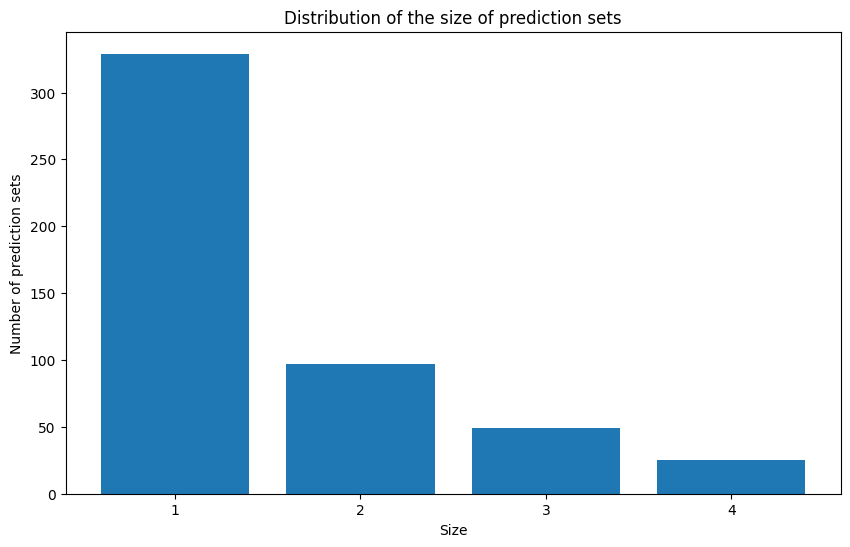

In [ ]:
plot_label_distribution(y_pred_set[:, :, 0])

In [ ]:
def plot_accuracy_per_size(y_test, y_pred_set):
    sizes = y_pred_set.sum(axis=1)
    unique_sizes = np.unique(sizes)
    accuracies = []
    for size in unique_sizes:
        # Indices where the prediction set size is equal to the current size
        indices = np.where(sizes == size)[0]
        # True labels and predictions for the current size
        true_labels = y_test[indices]
        predictions = y_pred[indices]
        # Accuracy calculation for the current size
        accuracy = accuracy_score(true_labels, predictions)
        accuracies.append(accuracy)
    accuracy = accuracy_score(y_test, y_pred)

    # plot horizontal line for global accuracy
    plt.axhline(y=accuracy, color='r', linestyle='--', label='Global Accuracy')

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.bar(unique_sizes.astype(int), accuracies)
    plt.title('Accuracy for each size of prediction sets')
    plt.xlabel('Size of Prediction Set')
    plt.ylabel('Accuracy')
    plt.xticks(unique_sizes.astype(int)) # set xticks to integers
    plt.show()


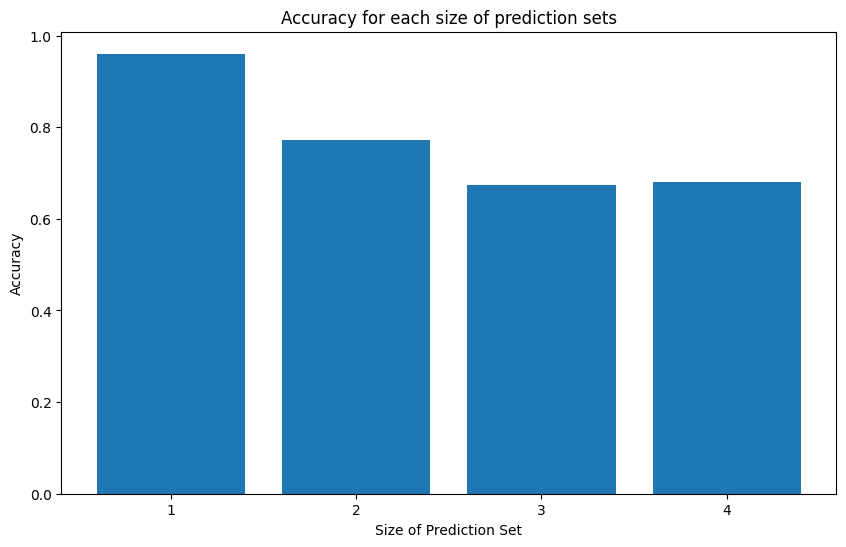

In [ ]:
plot_accuracy_per_size(y_test, y_pred_set[:, :, 0])
